In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [65]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, auc, roc_curve, f1_score
import dask_ml.model_selection as dcv

from sklearn.model_selection import train_test_split
import lightgbm as lgb

import random
import imblearn as imblearn
from sklearn.preprocessing import MinMaxScaler

import Modeling_Helper
import Processing

import optuna
from optuna.samplers import TPESampler


import shap
shap.initjs()


import warnings
warnings.simplefilter('always', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)
import statsmodels.api as sm


In [66]:
df = pd.read_csv('./data/merged_data.csv')
del df['Unnamed: 0']
modeling_data = df[[
    'person',
    'offer_id',
    'time_received',
    'offer_type',
    'duration',
    'offer_reward',
    'difficulty',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'gender', 
    'age',  
    'income',
    'membership_days',
    'membership_month', 
    'membership_year',
    'successful_offer'   
        ]]

In [67]:
cont_vars = [
    'duration',
    'num_channels',
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'age',  
    'income',
    'membership_days',
    'difficulty',

]

cat_vars = [
    'offer_id',
    'offer_type',
    'offer_reward',
    'gender', 
    'membership_month', 
    'membership_year'
]

features = cont_vars+cat_vars

y_var = 'successful_offer'

In [68]:
for i in cat_vars:
    modeling_data.loc[:, i] = modeling_data[i].astype('category')

In [69]:
modeling_data = modeling_data.sort_values(by = ['person', 'time_received']).reset_index(drop = True)
modeling_data['num_offers'] = modeling_data.groupby('person')['time_received'].transform(lambda group: group.astype('category').cat.codes + 1)
modeling_data['membership_month_sin'] = np.sin(2 * np.pi * modeling_data['membership_month'].astype(int) / 12)
modeling_data['membership_month_cos'] = np.cos(2 * np.pi * modeling_data['membership_month'].astype(int) / 12)
modeling_data['membership_days_X_income'] = modeling_data['membership_days']*modeling_data['income']
modeling_data['num_channels_X_income'] = modeling_data['num_channels']*modeling_data['income']
modeling_data['age_X_income'] = modeling_data['age']*modeling_data['income']

In [70]:
cont_vars = [
    'duration',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'age',  
    'income',
    'membership_days',
    'num_offers',
    'membership_days_X_income',
    'num_channels_X_income',
    'age_X_income',
    'membership_month_sin',
    'membership_month_cos',
    'difficulty',

]

cat_vars = [
    'offer_id',
    'offer_type',
    'offer_reward',
    'gender', 
    'membership_year'
]

features = cont_vars+cat_vars

y_var = 'successful_offer'

for i in cat_vars:
    modeling_data.loc[:, i] = modeling_data[i].astype('category')

In [71]:
data_split = Modeling_Helper.DataSplit('person', modeling_data, y_var, 0.8, 2021)
train_df, test_df = data_split.split_data()
print(len(train_df)/len(modeling_data), len(test_df)/len(modeling_data))
print(np.mean(train_df[y_var]), np.mean(test_df[y_var]))

scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)

0.7984077812198128 0.2015922187801872
0.029100087613167007 0.02899867812293457
33.36415770609319


In [9]:
best_params = {'learning_rate': 0.001651540420257919,
 'num_leaves': 26,
 'colsample_bytree': 0.5546771722017886,
 'reg_alpha': 0.11511983596488812,
 'reg_lambda': 1.402881028322646,
 'max_depth': 25,
 'min_child_samples': 470,
 'subsample': 0.966533554147176,
 'n_estimators': 660}
best_params

{'learning_rate': 0.001651540420257919,
 'num_leaves': 26,
 'colsample_bytree': 0.5546771722017886,
 'reg_alpha': 0.11511983596488812,
 'reg_lambda': 1.402881028322646,
 'max_depth': 25,
 'min_child_samples': 470,
 'subsample': 0.966533554147176,
 'n_estimators': 660}

In [14]:
param ={
    'learning_rate': best_params['learning_rate'],
    'num_leaves': best_params['num_leaves'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
    'max_depth':best_params['max_depth'],
    'min_child_samples': best_params['min_child_samples'], 
    'subsample': best_params['subsample'],
    'n_estimators': best_params['n_estimators'],
    'verbose': -1
        }


gbm_model = lgb.LGBMClassifier(objective = "binary", 
                               metric = ["auc", "binary_error"], 
                               random_state=2021, 
                               n_jobs=-1, 
                               scale_pos_weight = scale_pos_weight_val,
    learning_rate =  best_params['learning_rate'],
    num_leaves =  best_params['num_leaves'],
    colsample_bytree =  best_params['colsample_bytree'],
    reg_alpha =  best_params['reg_alpha'],
    reg_lambda =  best_params['reg_lambda'],
    max_depth = best_params['max_depth'],
    min_child_samples =  best_params['min_child_samples'], 
    subsample =  best_params['subsample'],
    n_estimators = best_params['n_estimators'],
    verbose =  -1                          )

gbm_model.fit(train_df[features], train_df[y_var], )

LGBMClassifier(colsample_bytree=0.5546771722017886,
               learning_rate=0.001651540420257919, max_depth=25,
               metric=['auc', 'binary_error'], min_child_samples=470,
               n_estimators=660, num_leaves=26, objective='binary',
               random_state=2021, reg_alpha=0.11511983596488812,
               reg_lambda=1.402881028322646, scale_pos_weight=33.36415770609319,
               subsample=0.966533554147176, verbose=-1)

************** Performance: Train Set **************** 

Accuracy: 0.92
Precision: 0.11
Recall: 0.24
F1: 0.15


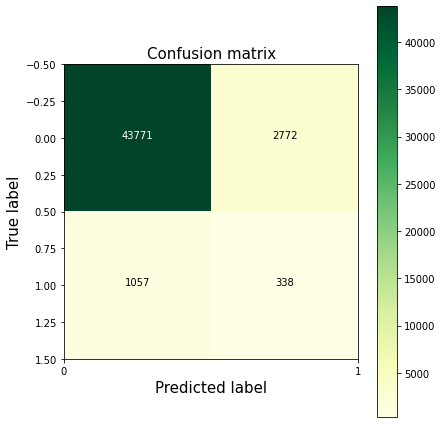

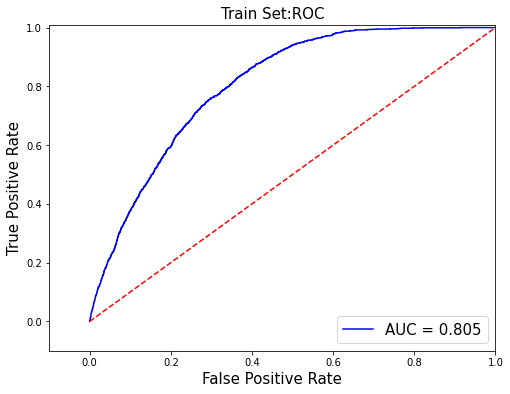

************** Performance: Test Set **************** 

Accuracy: 0.92
Precision: 0.11
Recall: 0.24
F1: 0.15


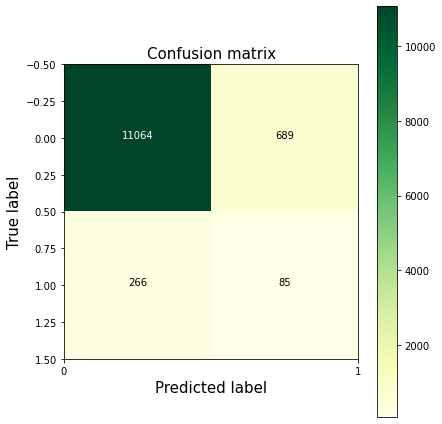

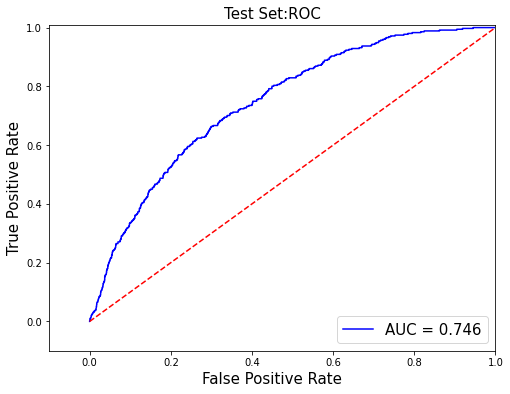

In [16]:
perf_analysis = Modeling_Helper.PerformanceAnalysis(gbm_model, train_df, features, y_var, 'Train Set', prob = True)
perf_analysis.perf_analysis()
perf_analysis = Modeling_Helper.PerformanceAnalysis(gbm_model, test_df, features, y_var, 'Test Set', prob = True)
perf_analysis.perf_analysis()

In [17]:
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(train_df[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


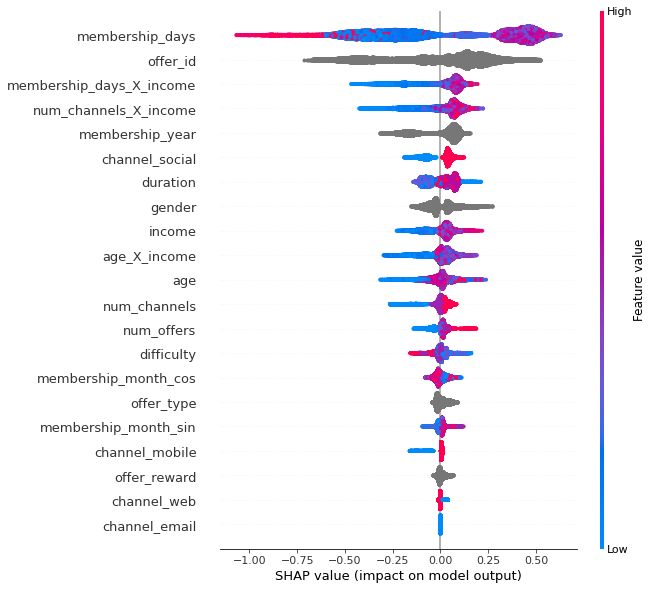

In [18]:
shap.summary_plot(shap_values[1], train_df[features], feature_names = features, max_display = 30)

In [54]:
data_prep = Processing.DataPrep()
portfolio = data_prep.portfolio_prep()
portfolio.head()

,offer_id,offer_type,num_channels,duration,offer_reward,difficulty,channel_email,channel_mobile,channel_social,channel_web
0,bogo_5_10,bogo,4,5,10,10,1,1,1,1
1,bogo_5_5,bogo,4,5,5,5,1,1,1,1
2,bogo_7_10,bogo,3,7,10,10,1,1,1,0
3,bogo_7_5,bogo,3,7,5,5,1,1,0,1
4,discount_10_2,discount,4,10,2,10,1,1,1,1


In [61]:
sorted(train_df.columns.tolist())

['age',
 'age_X_income',
 'best_uplift',
 'bogo_5_10',
 'bogo_5_5',
 'bogo_7_10',
 'bogo_7_5',
 'channel_email',
 'channel_mobile',
 'channel_social',
 'channel_web',
 'diff',
 'difficulty',
 'discount_10_2',
 'discount_10_5',
 'discount_7_2',
 'discount_7_3',
 'duration',
 'gender',
 'income',
 'informational',
 'informational_3',
 'informational_4',
 'membership_days',
 'membership_days_X_income',
 'membership_month',
 'membership_month_cos',
 'membership_month_sin',
 'membership_year',
 'num_channels',
 'num_channels_X_income',
 'num_offers',
 'offer_id',
 'offer_reward',
 'offer_type',
 'original_offer_id',
 'original_pred',
 'original_uplift',
 'person',
 'recom_offer',
 'successful_offer',
 'time_received']

In [84]:
data_split = Modeling_Helper.DataSplit('person', modeling_data, y_var, 0.8, 2021)
train_df, test_df = data_split.split_data()
print(len(train_df)/len(modeling_data), len(test_df)/len(modeling_data))
print(np.mean(train_df[y_var]), np.mean(test_df[y_var]))

scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)

0.7984077812198128 0.2015922187801872
0.029100087613167007 0.02899867812293457
33.36415770609319


In [85]:
train_df['original_offer_id'] = train_df['offer_id']
train_df['original_pred'] = gbm_model.predict_proba(train_df[features])[:, 1]

In [86]:
for i in portfolio['offer_id'].unique().tolist():
    temp = portfolio[portfolio['offer_id']==i].reset_index(drop = True)
    train_df['offer_id'] = i
    train_df = train_df[[x for x in train_df.columns.tolist() if x not in ['offer_type',
    'duration',
    'offer_reward',
    'difficulty',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web']]]
    train_df = train_df.merge(temp, on = ['offer_id'], how = 'left')
    train_df['num_channels_X_income'] = train_df['num_channels']*modeling_data['income']

    for j in cat_vars:
        train_df.loc[:, j] = train_df[j].astype('category')
    train_df[i] = gbm_model.predict_proba(train_df[features])[:, 1]
    

In [87]:
train_df['informational'] = train_df[['informational_3', 'informational_4']].max(axis=1)

offer_list = [
 'bogo_5_10',
 'bogo_5_5',
 'discount_10_2',
 'discount_10_5',
 'bogo_7_10',
 'discount_7_2',
 'discount_7_3',
 'bogo_7_5'
]

for i in offer_list:
    train_df[i] = train_df[i]-train_df['informational']
train_df['informational'] = 0

train_df['recom_offer'] = train_df[[ 'bogo_5_10',
 'bogo_5_5',
 'discount_10_2',
 'discount_10_5',
 'bogo_7_10',
 'discount_7_2',
 'discount_7_3',
 'bogo_7_5',
                                   'informational']].idxmax(axis=1)
train_df['best_uplift'] = train_df[[ 'bogo_5_10',
 'bogo_5_5',
 'discount_10_2',
 'discount_10_5',
 'bogo_7_10',
 'discount_7_2',
 'discount_7_3',
 'bogo_7_5']].max(axis=1)
train_df.head()  


,person,offer_id,time_received,gender,age,income,membership_days,membership_month,membership_year,successful_offer,...,offer_reward,difficulty,channel_email,channel_mobile,channel_social,channel_web,informational_4,informational,recom_offer,best_uplift
0,user_1000,informational_4,0.0,M,67.0,44000.0,1441.0,12.0,2017.0,0,...,0,0,1,1,0,1,0.096508,0,discount_7_3,0.024412
1,user_1000,informational_4,336.0,M,67.0,44000.0,1441.0,12.0,2017.0,0,...,0,0,1,1,0,1,0.108187,0,discount_7_3,0.014269
2,user_1000,informational_4,504.0,M,67.0,44000.0,1441.0,12.0,2017.0,0,...,0,0,1,1,0,1,0.113962,0,discount_7_3,0.013088
3,user_1000,informational_4,576.0,M,67.0,44000.0,1441.0,12.0,2017.0,0,...,0,0,1,1,0,1,0.116639,0,discount_7_3,0.011552
4,user_10001,informational_4,0.0,F,56.0,71000.0,1932.0,8.0,2016.0,0,...,0,0,1,1,0,1,0.218849,0,discount_7_3,0.114843


In [24]:
# train_df['original_offer_id'] = train_df['offer_id']
# for i in train_df['original_offer_id'].unique().tolist():
#     train_df['offer_id'] = i
#     train_df.loc[:, 'offer_id'] = train_df['offer_id'].astype('category')
#     train_df[i] = gbm_model.predict_proba(train_df[features])[:, 1]
# train_df['informational'] = train_df[['informational_3', 'informational_4']].max(axis=1)

# offer_list = [
#  'bogo_5_10',
#  'bogo_5_5',
#  'discount_10_2',
#  'discount_10_5',
#  'bogo_7_10',
#  'discount_7_2',
#  'discount_7_3',
#  'bogo_7_5'
# ]

# for i in offer_list:
#     train_df[i] = train_df[i]-train_df['informational']
# train_df['informational'] = 0

# train_df['recom_offer'] = train_df[[ 'bogo_5_10',
#  'bogo_5_5',
#  'discount_10_2',
#  'discount_10_5',
#  'bogo_7_10',
#  'discount_7_2',
#  'discount_7_3',
#  'bogo_7_5',
#                                    'informational']].idxmax(axis=1)
# train_df['best_uplift'] = train_df[[ 'bogo_5_10',
#  'bogo_5_5',
#  'discount_10_2',
#  'discount_10_5',
#  'bogo_7_10',
#  'discount_7_2',
#  'discount_7_3',
#  'bogo_7_5']].max(axis=1)
# train_df.head()    

In [46]:
# train_df['offer_id'] = train_original_offer_id

In [47]:
# train_df['original_pred'] = gbm_model.predict_proba(train_df[features])[:, 1]

In [49]:
for i in train_df['original_offer_id'].unique().tolist():
    train_df['offer_id'] = i
    train_df.loc[:, 'offer_id'] = train_df['offer_id'].astype('category')
    train_df[i] = gbm_model.predict_proba(train_df[features])[:, 1]
train_df['informational'] = train_df[['informational_3', 'informational_4']].max(axis=1)

offer_list = [
 'bogo_5_10',
 'bogo_5_5',
 'discount_10_2',
 'discount_10_5',
 'bogo_7_10',
 'discount_7_2',
 'discount_7_3',
 'bogo_7_5'
]

for i in offer_list:
    train_df['original_uplift'] = train_df['original_pred']-train_df['informational']

train_df.head()

,person,offer_id,time_received,offer_type,duration,offer_reward,difficulty,num_channels,channel_email,channel_mobile,...,bogo_7_10,discount_7_2,discount_7_3,bogo_7_5,informational,recom_offer,best_uplift,diff,original_pred,original_uplift
4,user_1000,bogo_7_5,0.0,bogo,5.0,10,10,4,1,1,...,0.131454,0.093955,0.137701,0.093248,0.136319,discount_7_3,0.001382,0,0.078937,-0.057382
5,user_1000,bogo_7_5,336.0,bogo,5.0,5,5,4,1,1,...,0.155057,0.107795,0.161327,0.108653,0.160041,discount_7_3,0.001286,0,0.150803,-0.009238
6,user_1000,bogo_7_5,504.0,bogo,5.0,5,5,4,1,1,...,0.161231,0.117518,0.168665,0.117158,0.167739,discount_7_3,0.000925,0,0.158228,-0.009511
7,user_1000,bogo_7_5,576.0,informational,3.0,0,0,3,1,1,...,0.195990,0.134299,0.210483,0.141512,0.210918,informational,-0.000435,0,0.210918,0.000000
8,user_10001,bogo_7_5,0.0,discount,10.0,2,10,4,1,1,...,0.521229,0.476445,0.523333,0.517268,0.495450,discount_10_2,0.027883,1,0.523333,0.027883


In [50]:
def auuc_calculation(data, treat_var, y_var, n = 100, plot = False, random_seed = 2021):
    
#     model_names = ['Model', 'Rand_1', 'Rand_2','Rand_3','Rand_4','Rand_5','Rand_6','Rand_7','Rand_8','Rand_9','Rand_10',]

    data['best_uplift'] = data['original_uplift']
    
    model_names = ['Model']+ ['Rand_'+str(x) for x in range(1,41)]

    df_preds = data[['best_uplift', treat_var, y_var]]
    df_preds['is_treated'] = np.where(data[treat_var].isin(['informational_3', 'informational_4']), 0 , 1)
    df_preds = df_preds.sort_values('best_uplift', ascending=False).reset_index(drop=True)
    df_preds.index = df_preds.index + 1
    df_preds['cumsum_tr'] = df_preds['is_treated'].cumsum()
    df_preds['cumsum_ct'] = df_preds.index.values - df_preds['cumsum_tr']
    df_preds['cumsum_y_tr'] = (df_preds[y_var] * df_preds['is_treated']).cumsum()
    df_preds['cumsum_y_ct'] = (df_preds[y_var] * (1 - df_preds['is_treated'])).cumsum()
    df_preds['lift'] = df_preds['cumsum_y_tr'] / df_preds['cumsum_tr'] - df_preds['cumsum_y_ct'] / df_preds['cumsum_ct']
    lift = []
    lift.append(df_preds['cumsum_y_tr'] / df_preds['cumsum_tr'] - df_preds['cumsum_y_ct'] / df_preds['cumsum_ct'])


    np.random.seed(random_seed)
    
    for i in range(40):
        df_preds = data[['best_uplift', treat_var, y_var]]
        df_preds['best_uplift'] = np.random.rand(df_preds.shape[0])
        df_preds['is_treated'] = np.where(data[treat_var].isin(['informational_3', 'informational_4']), 0 , 1)

    #     df_preds['is_treated'] = df_preds['Recipe']

        df_preds = df_preds.sort_values('best_uplift', ascending=False).reset_index(drop=True)
        df_preds.index = df_preds.index + 1
        df_preds['cumsum_tr'] = df_preds['is_treated'].cumsum()
        df_preds['cumsum_ct'] = df_preds.index.values - df_preds['cumsum_tr']
        df_preds['cumsum_y_tr'] = (df_preds[y_var] * df_preds['is_treated']).cumsum()
        df_preds['cumsum_y_ct'] = (df_preds[y_var] * (1 - df_preds['is_treated'])).cumsum()
        df_preds['lift'] = df_preds['cumsum_y_tr'] / df_preds['cumsum_tr'] - df_preds['cumsum_y_ct'] / df_preds['cumsum_ct']
        lift.append(df_preds['cumsum_y_tr'] / df_preds['cumsum_tr'] - df_preds['cumsum_y_ct'] / df_preds['cumsum_ct'])

    lift = pd.concat(lift, join='inner', axis=1)
    lift.loc[0] = np.zeros((lift.shape[1], ))
    lift = lift.sort_index().interpolate()

    lift.columns = model_names
    lift['RANDOM'] = lift[model_names[1:]].mean(axis=1) 
    lift.drop(model_names[1:], axis=1, inplace=True)
    gain = lift.mul(lift.index.values, axis=0)

    gain = gain.div(np.abs(gain.iloc[-1, :]), axis=1)
#     print('Model AUUC: ', gain['Model'].sum() / gain['Model'].shape[0])
#     print('Random AUUC: ', gain['RANDOM'].sum() / gain['RANDOM'].shape[0])

        
    if plot:
        
        gain = gain.iloc[np.linspace(0, gain.index[-1], n, endpoint=True)]
        
        plt.figure(figsize = (7,6))
        pp = plt.plot(gain)
        plt.xlabel('Population')
        plt.ylabel('Gain')
        plt.legend([pp[0], pp[1]], ['Model', 'Random'])
        plt.show()
        
    return({'model_AUUC': gain['Model'].sum() / gain['Model'].shape[0], 'random_AUUC': gain['RANDOM'].sum() / gain['RANDOM'].shape[0]})

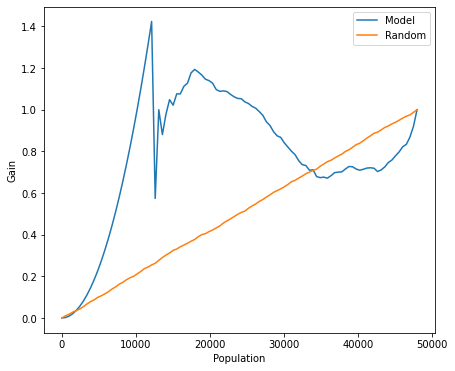

{'model_AUUC': 0.7828109615288247, 'random_AUUC': 0.5017671189128048}

In [53]:
auuc_calculation(train_df, 'original_offer_id', y_var, n = 100, plot = True, random_seed = 2021)

In [88]:
def auuc_calculation(data, treat_var, y_var, n = 100, plot = False, random_seed = 2021):
    
#     model_names = ['Model', 'Rand_1', 'Rand_2','Rand_3','Rand_4','Rand_5','Rand_6','Rand_7','Rand_8','Rand_9','Rand_10',]
    
    model_names = ['Model']+ ['Rand_'+str(x) for x in range(1,41)]

    df_preds = data[['best_uplift', treat_var, y_var]]
    df_preds['is_treated'] = np.where(data[treat_var].isin(['informational_3', 'informational_4']), 0 , 1)
    df_preds = df_preds.sort_values('best_uplift', ascending=False).reset_index(drop=True)
    df_preds.index = df_preds.index + 1
    df_preds['cumsum_tr'] = df_preds['is_treated'].cumsum()
    df_preds['cumsum_ct'] = df_preds.index.values - df_preds['cumsum_tr']
    df_preds['cumsum_y_tr'] = (df_preds[y_var] * df_preds['is_treated']).cumsum()
    df_preds['cumsum_y_ct'] = (df_preds[y_var] * (1 - df_preds['is_treated'])).cumsum()
    df_preds['lift'] = df_preds['cumsum_y_tr'] / df_preds['cumsum_tr'] - df_preds['cumsum_y_ct'] / df_preds['cumsum_ct']
    lift = []
    lift.append(df_preds['cumsum_y_tr'] / df_preds['cumsum_tr'] - df_preds['cumsum_y_ct'] / df_preds['cumsum_ct'])


    np.random.seed(random_seed)
    
    for i in range(40):
        df_preds = data[['best_uplift', treat_var, y_var]]
        df_preds['best_uplift'] = np.random.rand(df_preds.shape[0])
        df_preds['is_treated'] = np.where(data[treat_var].isin(['informational_3', 'informational_4']), 0 , 1)

    #     df_preds['is_treated'] = df_preds['Recipe']

        df_preds = df_preds.sort_values('best_uplift', ascending=False).reset_index(drop=True)
        df_preds.index = df_preds.index + 1
        df_preds['cumsum_tr'] = df_preds['is_treated'].cumsum()
        df_preds['cumsum_ct'] = df_preds.index.values - df_preds['cumsum_tr']
        df_preds['cumsum_y_tr'] = (df_preds[y_var] * df_preds['is_treated']).cumsum()
        df_preds['cumsum_y_ct'] = (df_preds[y_var] * (1 - df_preds['is_treated'])).cumsum()
        df_preds['lift'] = df_preds['cumsum_y_tr'] / df_preds['cumsum_tr'] - df_preds['cumsum_y_ct'] / df_preds['cumsum_ct']
        lift.append(df_preds['cumsum_y_tr'] / df_preds['cumsum_tr'] - df_preds['cumsum_y_ct'] / df_preds['cumsum_ct'])

    lift = pd.concat(lift, join='inner', axis=1)
    lift.loc[0] = np.zeros((lift.shape[1], ))
    lift = lift.sort_index().interpolate()

    lift.columns = model_names
    lift['RANDOM'] = lift[model_names[1:]].mean(axis=1) 
    lift.drop(model_names[1:], axis=1, inplace=True)
    gain = lift.mul(lift.index.values, axis=0)

    gain = gain.div(np.abs(gain.iloc[-1, :]), axis=1)
#     print('Model AUUC: ', gain['Model'].sum() / gain['Model'].shape[0])
#     print('Random AUUC: ', gain['RANDOM'].sum() / gain['RANDOM'].shape[0])

        
    if plot:
        
        gain = gain.iloc[np.linspace(0, gain.index[-1], n, endpoint=True)]
        
        plt.figure(figsize = (7,6))
        pp = plt.plot(gain)
        plt.xlabel('Population')
        plt.ylabel('Gain')
        plt.legend([pp[0], pp[1]], ['Model', 'Random'])
        plt.show()
        
    return({'model_AUUC': gain['Model'].sum() / gain['Model'].shape[0], 'random_AUUC': gain['RANDOM'].sum() / gain['RANDOM'].shape[0]})

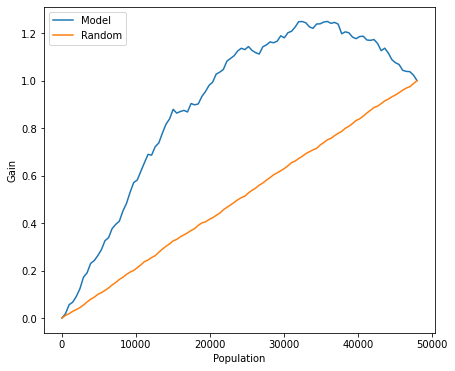

{'model_AUUC': 0.8937310965569718, 'random_AUUC': 0.5017671189128048}

In [89]:
auuc_calculation(train_df, 'original_offer_id', y_var, n = 100, plot = True, random_seed = 2021)

In [39]:
test_df['original_offer_id'] = test_df['offer_id']
for i in test_df['original_offer_id'].unique().tolist():
    test_df['offer_id'] = i
    test_df.loc[:, 'offer_id'] = test_df['offer_id'].astype('category')
    test_df[i] = gbm_model.predict_proba(test_df[features])[:, 1]
test_df['informational'] = test_df[['informational_3', 'informational_4']].max(axis=1)

offer_list = [
 'bogo_5_10',
 'bogo_5_5',
 'discount_10_2',
 'discount_10_5',
 'bogo_7_10',
 'discount_7_2',
 'discount_7_3',
 'bogo_7_5'
]

for i in offer_list:
    test_df[i] = test_df[i]-test_df['informational']
test_df['informational'] = 0

test_df['recom_offer'] = test_df[[ 'bogo_5_10',
 'bogo_5_5',
 'discount_10_2',
 'discount_10_5',
 'bogo_7_10',
 'discount_7_2',
 'discount_7_3',
 'bogo_7_5',
                                   'informational']].idxmax(axis=1)
test_df['best_uplift'] = test_df[[ 'bogo_5_10',
 'bogo_5_5',
 'discount_10_2',
 'discount_10_5',
 'bogo_7_10',
 'discount_7_2',
 'discount_7_3',
 'bogo_7_5']].max(axis=1)
test_df.head()    

,person,offer_id,time_received,offer_type,duration,offer_reward,difficulty,num_channels,channel_email,channel_mobile,...,bogo_5_5,bogo_7_5,bogo_5_10,discount_10_2,discount_7_2,informational_3,discount_7_3,informational,recom_offer,best_uplift
0,user_100,discount_7_3,0.0,discount,10.0,5,20,2,1,0,...,-0.013330,0.023727,-0.015908,0.030626,-0.014726,0.235581,0.030626,0,discount_10_2,0.030626
1,user_100,discount_7_3,336.0,bogo,7.0,10,10,3,1,1,...,-0.006155,0.018093,-0.011716,0.024415,-0.011324,0.458985,0.024415,0,discount_10_2,0.024415
2,user_100,discount_7_3,408.0,informational,4.0,0,0,3,1,1,...,-0.008501,0.016767,-0.012899,0.022687,-0.011907,0.352810,0.022687,0,discount_10_2,0.022687
3,user_100,discount_7_3,576.0,discount,10.0,5,20,2,1,0,...,-0.014411,0.023789,-0.017054,0.028064,-0.015842,0.244552,0.028064,0,discount_10_2,0.028064
28,user_10006,discount_7_3,0.0,bogo,5.0,5,5,4,1,1,...,-0.000543,0.016976,-0.004122,0.021792,-0.003138,0.406022,0.021792,0,discount_10_2,0.021792


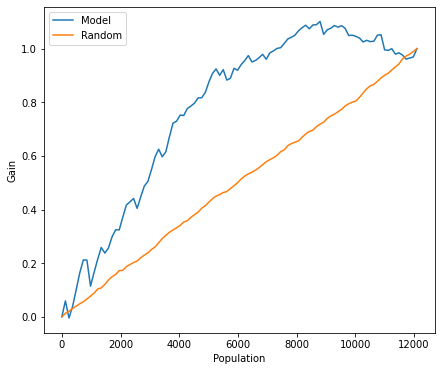

{'model_AUUC': 0.7720130337702672, 'random_AUUC': 0.4992677689215394}

In [40]:
auuc_calculation(test_df, 'original_offer_id', y_var, n = 100, plot = True, random_seed = 2021)

In [43]:
train_df['diff'] = np.where((train_df['original_offer_id'].isin(['informational_3', 'informational_4']) & train_df['recom_offer'] == 'informational'), 1,
                           np.where(train_df['original_offer_id'] == train_df['recom_offer'], 1, 0))

In [44]:
train_df['diff'].mean()

0.09570695481663816